In [1]:
import pandas as pd
from other_utils import pca_tsne_mols
import plotly.express as px

import rdkit
from rdkit import Chem

# shut off warnings
from rdkit import RDLogger                                                                                                                                                               
RDLogger.DisableLog('rdApp.*')  

import matplotlib
from matplotlib import rc
font = {'size'   : 8}
matplotlib.rc('font', **font)

# change font
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Part 1: Read in and process all possible datasets for comparisons

### Combine data from different sources

In [3]:
# take in primary screen data
df = pd.read_excel('../data/TrainingDataRound1_wValidation.xlsx')
print('num drugs: ' + str(len(df)))
thresh = 0.2
secondchoice = list((df['Rep1_Inhibition'] < thresh) & (df['Rep2_Inhibition'] < thresh))
test = list(df['Inhibition Hit'])
corrected = []
for i in range(len(test)):
    if test[i] == 1.0:
        corrected.append(True)
    elif test[i] == 0.0:
        corrected.append(False)
    else:
        corrected.append(secondchoice[i])
df['inh_hit'] = corrected
df['kill_hit'] = [True if x == 1.0 else False for x in list(df['Killing Hit'])]

df = df[['SMILES', 'Name', 'inh_hit', 'kill_hit']]

# add in validated killing ML predictions from round 1
small = pd.read_excel('../data/800kPredictionTestingData.xlsx', header = 0)
small = small.dropna(subset=['GI_Validation', 'Killing_Validation'])
inh_thresh = 0.2
kill_thresh = 4.37e6
small['hit_inh'] = [1.0 if i < inh_thresh else 0.0 for i in small['GI_Validation']]
small['hit_kill'] = [1.0 if i < kill_thresh else 0.0 for i in small['Killing_Validation']]
small = small[['SMILES', 'Name', 'hit_inh', 'hit_kill']]
small.columns = ['SMILES', 'Name', 'inh_hit', 'kill_hit']
df = pd.concat([df,small])

# add in validated killing ML predictions from round 2
small = pd.read_csv('../data/ML_curations_round2.csv')
small['inh_hit'] = [1.0 if x < inh_thresh and y < inh_thresh and z < inh_thresh else 0.0 for x,y,z in zip(small['LB_OD-Rep1'],small['LB_OD-Rep2'],small['LB_OD-Rep3'])]
small['kill_hit'] = [1.0 if x < kill_thresh and y < kill_thresh else 0.0 for x,y in zip(small['CFU_ml-Rep1'], small['CFU_ml-Rep2'])]
small = small[['SMILES', 'Name', 'inh_hit', 'kill_hit']]
df = pd.concat([df,small])

num drugs: 6720


/var/folders/py/8hwb28r933z4xh4q0dw5hz2h0000gn/T/ipykernel_3531/534269948.py:29: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  df = pd.concat([df,small])


### Separate out by activity

In [4]:
nonhits = df[(df['inh_hit'] == 0) & (df['kill_hit'] == 0)]
print('non_hits', len(nonhits))
nonhits = nonhits[[type(x) != float for x in list(nonhits['SMILES'])]]
nh_smiles = list(nonhits['SMILES'])
nh_mols = [Chem.MolFromSmiles(x) for x in nh_smiles]
nonhit_fps, nh_names = zip(*[(Chem.RDKFingerprint(x),y) for x,y in zip(nh_mols,list(nonhits['Name'])) if x is not None])

kill_hits_only = df[(df['kill_hit'] == 1) & (df['inh_hit'] == 0)]
print('kill_hits_only', len(kill_hits_only))
kill_hits_only_smiles = list(kill_hits_only['SMILES'])
kill_hits_only_mols = [Chem.MolFromSmiles(x) for x in kill_hits_only_smiles]
kill_hits_only_fps, kill_hits_only_names = zip(*[(Chem.RDKFingerprint(x),y) for x,y in zip(kill_hits_only_mols,list(kill_hits_only['Name'])) if x is not None])

inh_hits_only = df[(df['kill_hit'] == 0) & (df['inh_hit'] == 1)]
print('inh_hits_only', len(inh_hits_only))
inh_hits_only_smiles = list(inh_hits_only['SMILES'])
inh_hits_only_mols = [Chem.MolFromSmiles(x) for x in inh_hits_only_smiles]
inh_hits_only_fps, inh_hits_only_names = zip(*[(Chem.RDKFingerprint(x),y) for x,y in zip(inh_hits_only_mols,list(inh_hits_only['Name'])) if x is not None])

both_hits = df[(df['kill_hit'] == 1) & (df['inh_hit'] == 1)]
print('both_hits', len(both_hits))
both_hits_smiles = list(both_hits['SMILES'])
both_hits_mols = [Chem.MolFromSmiles(x) for x in both_hits_smiles]
both_hits_fps, both_hits_names = zip(*[(Chem.RDKFingerprint(x),y) for x,y in zip(both_hits_mols,list(both_hits['Name'])) if x is not None])

non_hits 6699
kill_hits_only 30
inh_hits_only 92
both_hits 75


### Add antibiotics

In [5]:
# get morgan fingerprints for abx
abx = pd.read_csv('../data/curated_set_of_566_abx.csv')
abx = abx[[type(x) != float for x in list(abx['Smiles'])]]
abx_smiles = list(abx['Smiles'])
mols = [Chem.MolFromSmiles(x) for x in abx_smiles]
abx_fps, abx_names, abx_classes = zip(*[(Chem.RDKFingerprint(x),y,z) for x,y,z in zip(mols,list(abx['Name']),list(abx['Class-Annotated'])) if x is not None])

In [6]:
fp_list = list(nonhit_fps)
fp_list.extend(abx_fps)
fp_list.extend(kill_hits_only_fps)
fp_list.extend(inh_hits_only_fps)
fp_list.extend(both_hits_fps)

fp_labels = ['Non-Hits'] * len(nonhit_fps)
fp_labels.extend(['Known Antibiotics'] * len(abx_fps))
fp_labels.extend(['Stat Phase Lethal Activity Only'] * len(kill_hits_only_fps))
fp_labels.extend(['Growth Inhibition Activity Only'] * len(inh_hits_only_fps))
fp_labels.extend(['Both Inhibition and Lethality Activity'] * len(both_hits_fps))

# Part 3: Perform PCA and t-SNE

variance explained by pc1+pc2: 0.2087397022062938


/Users/jackie16201/opt/anaconda3/envs/chemprop010821/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/jackie16201/opt/anaconda3/envs/chemprop010821/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


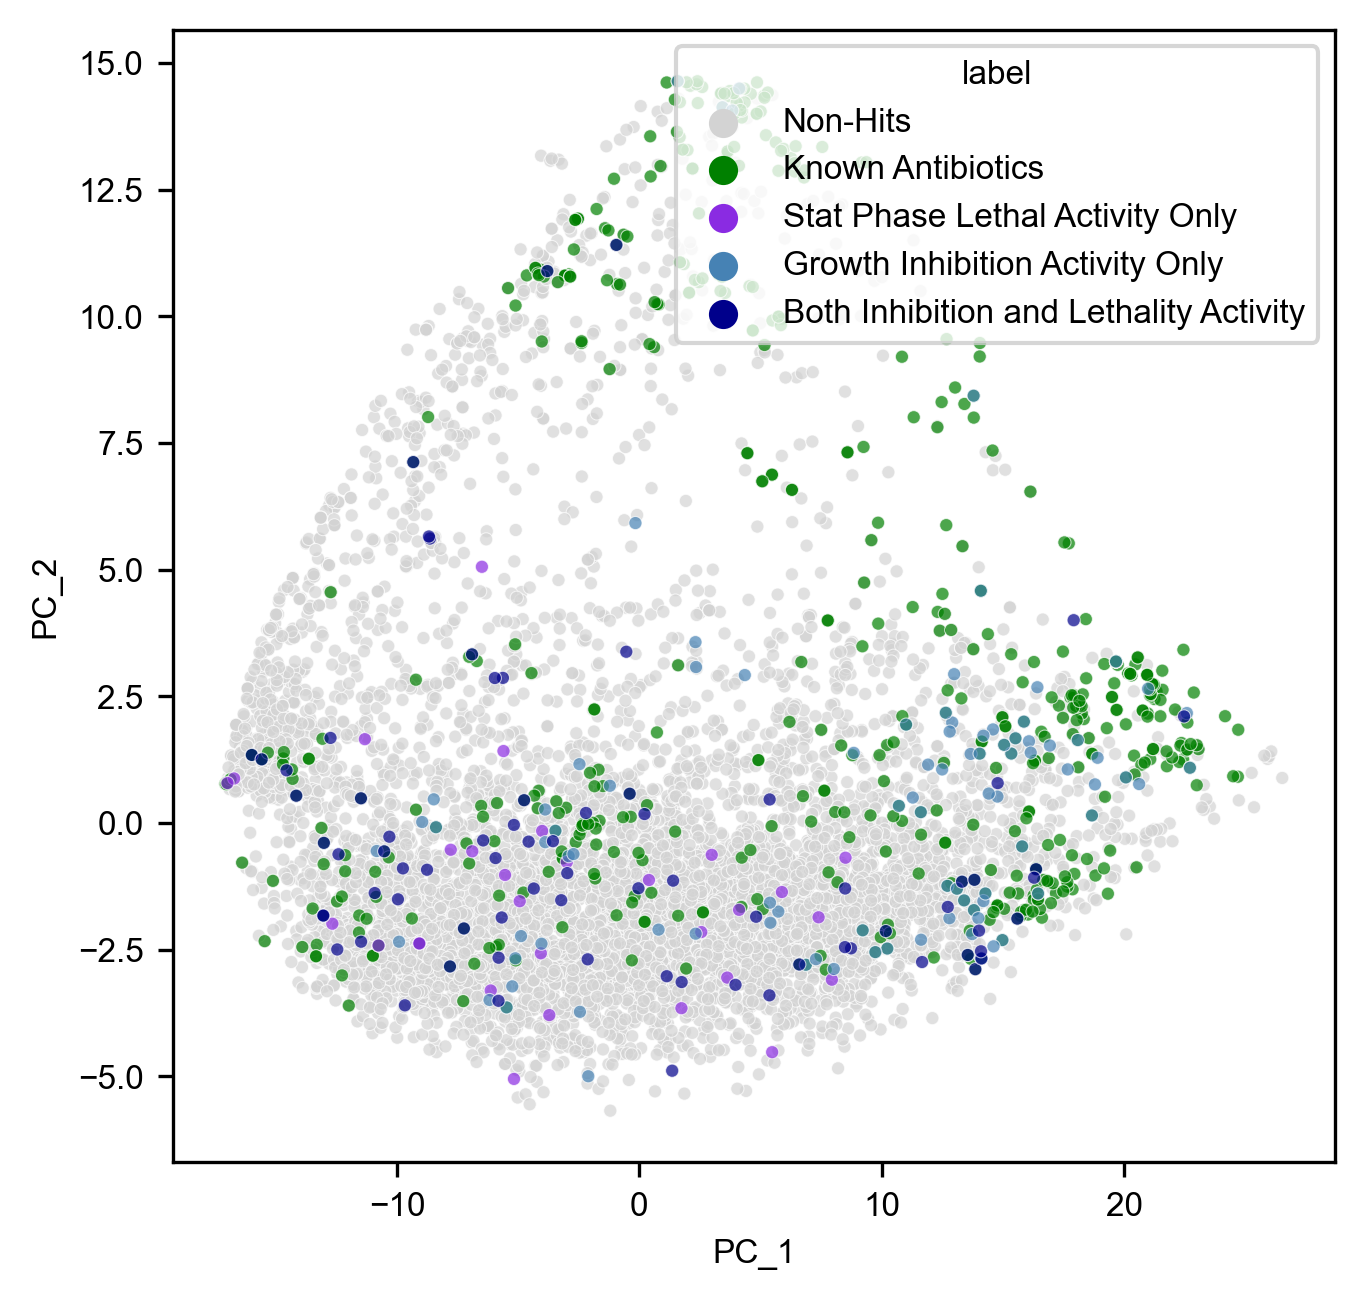

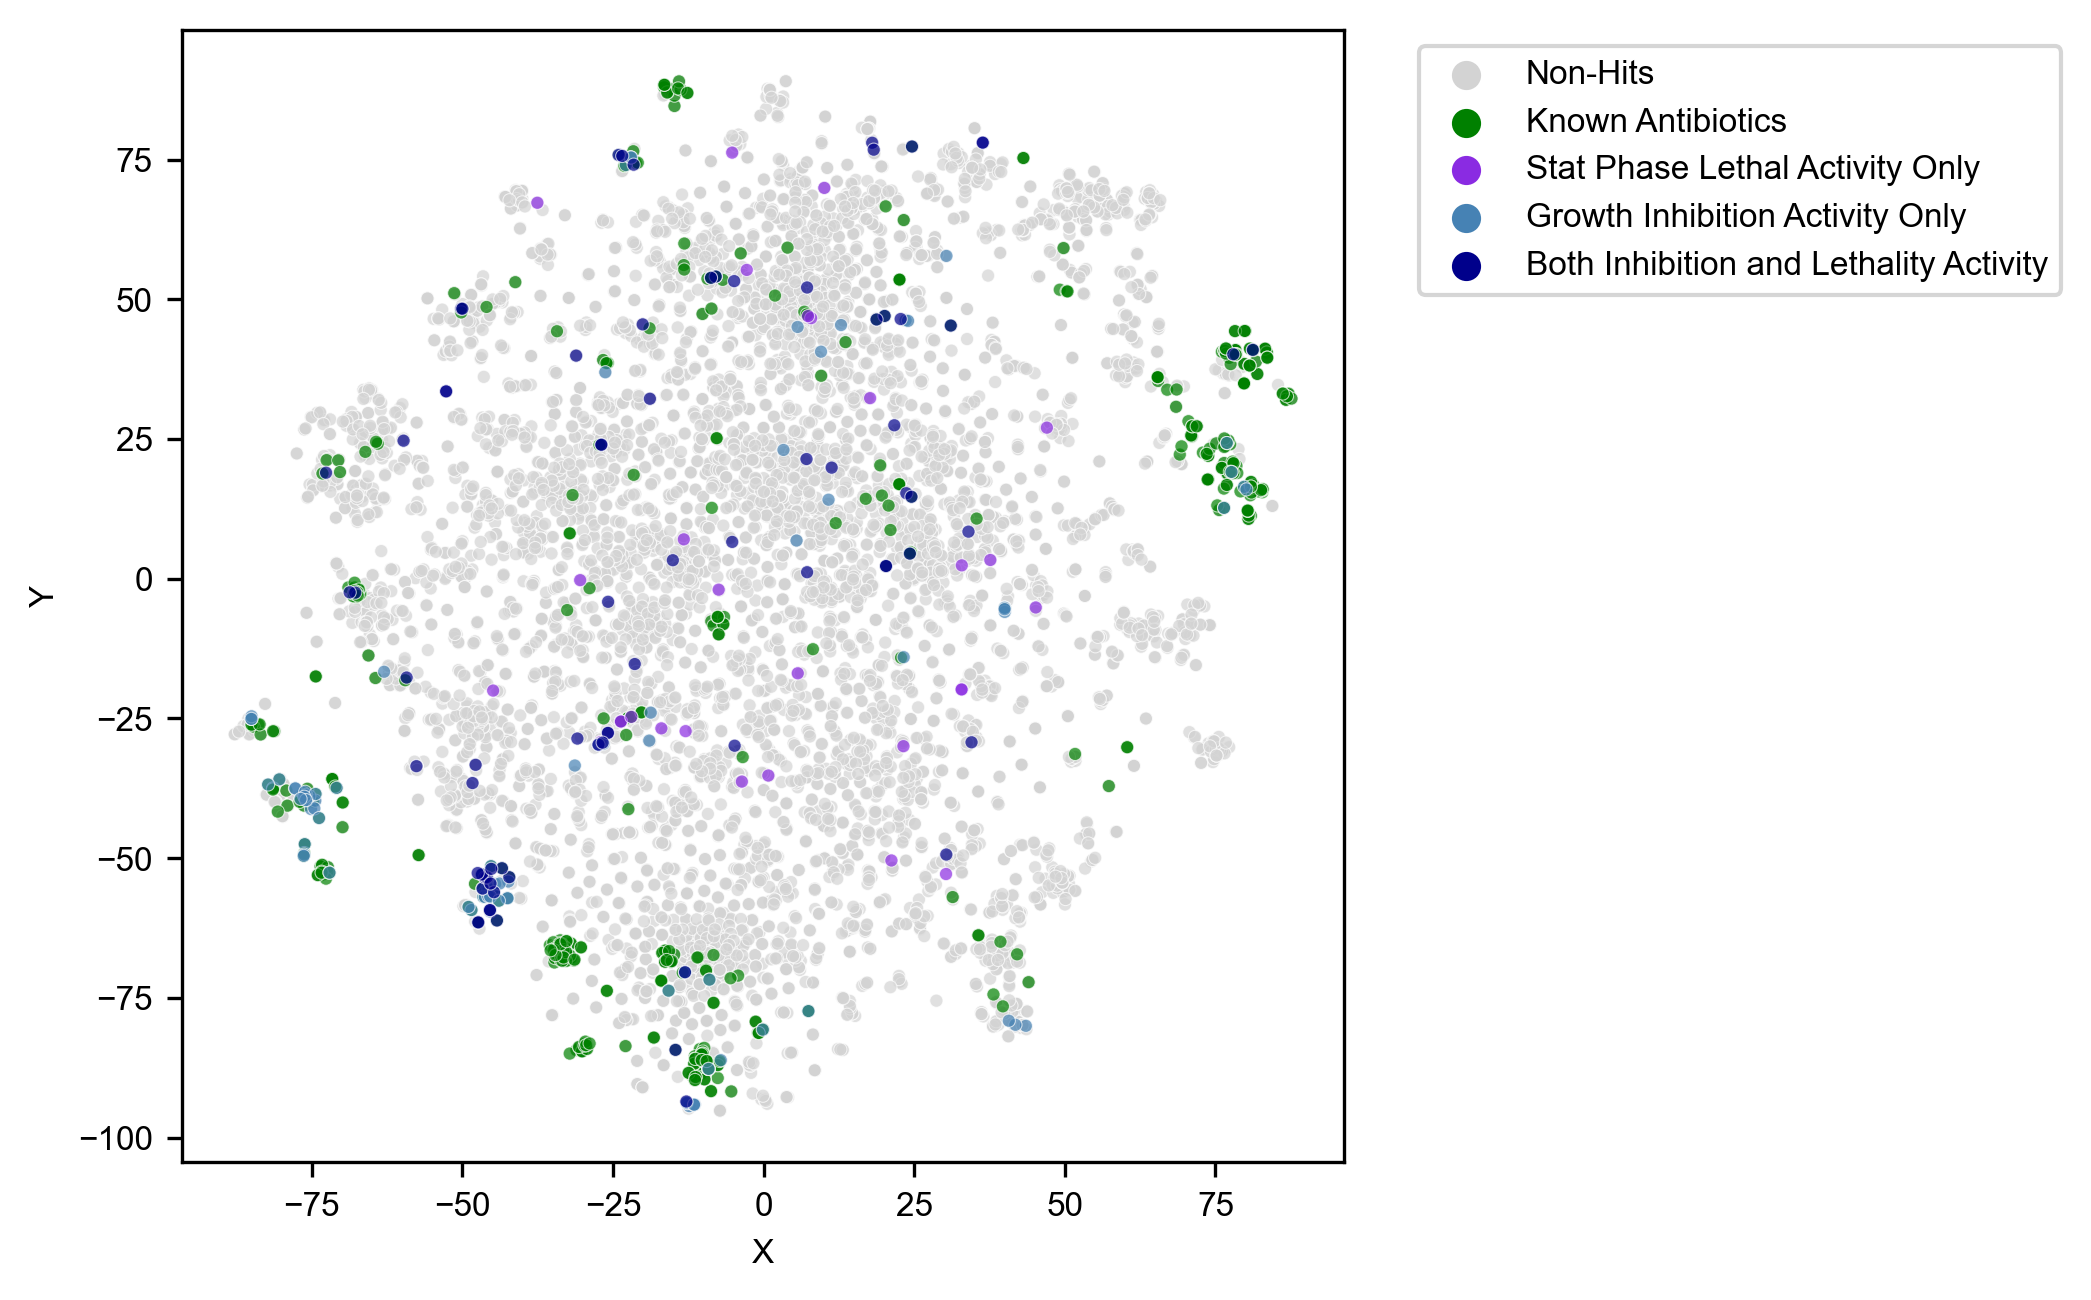

In [7]:
colors_for_vis = ['lightgray','green','blueviolet', 'steelblue','darkblue']
tsne_df = pca_tsne_mols(fp_list, fp_labels, colors_for_vis)

# Part 4: Get additional information for interactive display

In [8]:
name_list = list(nh_names)
name_list.extend(abx_names)
name_list.extend(kill_hits_only_names)
name_list.extend(inh_hits_only_names)
name_list.extend(both_hits_names)

smis_list = list(nh_smiles)
smis_list.extend(abx_smiles)
smis_list.extend(kill_hits_only_smiles)
smis_list.extend(inh_hits_only_smiles)
smis_list.extend(both_hits_smiles)

testdf = tsne_df
testdf['Name'] = name_list
testdf['SMILES'] = smis_list

# clean up display so only 2 dec
abx = abx[['Smiles', 'Class-Annotated']]
abx = abx.drop_duplicates('Smiles')
testdf = testdf.merge(abx, left_on = 'SMILES', right_on = 'Smiles', how = 'left')
testdf = testdf.fillna('N/A')

In [9]:
testdf

X          Y                                   label  \
0    -14.455294 -29.987400                                Non-Hits   
1     20.733936  12.962986                                Non-Hits   
2    -47.621998 -24.920059                                Non-Hits   
3     -4.432959 -30.761251                                Non-Hits   
4    -31.476879  -9.464285                                Non-Hits   
...         ...        ...                                     ...   
7448 -47.441460 -52.660667  Both Inhibition and Lethality Activity   
7449  -4.797892 -29.876596  Both Inhibition and Lethality Activity   
7450 -30.901611 -28.595840  Both Inhibition and Lethality Activity   
7451  -5.201337   6.590204  Both Inhibition and Lethality Activity   
7452 -25.803623  -4.128621  Both Inhibition and Lethality Activity   

                 Name                                             SMILES  \
0            EHop-016     CCn1c2ccccc2c2cc(Nc3ccnc(NCCCN4CCOCC4)n3)ccc12   
1        hydroquinone                                       Oc1ccc(O)cc1   
2          serdemetan           C(Cc1c[nH]c2ccccc12)Nc1ccc(Nc2ccncc2)cc1   
3                DBeQ             C(Nc1nc(NCc2ccccc2)c2ccccc2n1)c1ccccc1   
4         elacestrant  CCNCCc1ccc(CN(CC)c2cc(OC)ccc2[C@@H]2CCc3cc(O)c...   
...               ...                                                ...   
7448    BRD-K71926323    CN1CCN(CC1)c1c(cc2c3c1OCN(C)N3C=C(C(=O)O)C2=O)F   
7449    BRD-K17140735     CC(C)c1ccc(cc1)Cn1ccc2c1ccc1nc(nc(c12)N)NC1CC1   
7450         99546031  Cl.Cl.CN1C(CN2C[C@@H]3CCN[C@@H]3C2)=CC2=CC(C)=...   
7451  AN-465/43384139    Cl.Cl.ClC1=CC=C(COC2=CC=C(CNCC3CCNCC3)C=C2)C=C1   
7452  AN-465/43384067              Clc1ccc(Cl)c(-c2ccc(CNCC3CCNCC3)o2)c1   

     Smiles Class-Annotated  
0       N/A             N/A  
1       N/A             N/A  
2       N/A             N/A  
3       N/A             N/A  
4       N/A             N/A  
...     ...             ...  
7448    N/A             N/A  
7449    N/A             N/A  
7450    N/A             N/A  
7451    N/A             N/A  
7452    N/A             N/A  

[7453 rows x 7 columns]

In [10]:
# actually make the interactive plot
hover_labels = ['X', 'Y', 'label', 'Name', 'SMILES', 'Class-Annotated']
hover_bools = [True, True, True, True, True, True]

fig = px.scatter(testdf, x = 'X', y = 'Y', opacity = 0.75, color =  testdf['label'], hover_data = dict(zip(hover_labels, hover_bools)), color_discrete_sequence=colors_for_vis)
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.show()

In [11]:
testdf.to_csv('../out/tsne_data_plus_annotated_mechanism_plus_val_ML_mols.csv', index = False)
testdf

X          Y                                   label  \
0    -14.455294 -29.987400                                Non-Hits   
1     20.733936  12.962986                                Non-Hits   
2    -47.621998 -24.920059                                Non-Hits   
3     -4.432959 -30.761251                                Non-Hits   
4    -31.476879  -9.464285                                Non-Hits   
...         ...        ...                                     ...   
7448 -47.441460 -52.660667  Both Inhibition and Lethality Activity   
7449  -4.797892 -29.876596  Both Inhibition and Lethality Activity   
7450 -30.901611 -28.595840  Both Inhibition and Lethality Activity   
7451  -5.201337   6.590204  Both Inhibition and Lethality Activity   
7452 -25.803623  -4.128621  Both Inhibition and Lethality Activity   

                 Name                                             SMILES  \
0            EHop-016     CCn1c2ccccc2c2cc(Nc3ccnc(NCCCN4CCOCC4)n3)ccc12   
1        hydroquinone                                       Oc1ccc(O)cc1   
2          serdemetan           C(Cc1c[nH]c2ccccc12)Nc1ccc(Nc2ccncc2)cc1   
3                DBeQ             C(Nc1nc(NCc2ccccc2)c2ccccc2n1)c1ccccc1   
4         elacestrant  CCNCCc1ccc(CN(CC)c2cc(OC)ccc2[C@@H]2CCc3cc(O)c...   
...               ...                                                ...   
7448    BRD-K71926323    CN1CCN(CC1)c1c(cc2c3c1OCN(C)N3C=C(C(=O)O)C2=O)F   
7449    BRD-K17140735     CC(C)c1ccc(cc1)Cn1ccc2c1ccc1nc(nc(c12)N)NC1CC1   
7450         99546031  Cl.Cl.CN1C(CN2C[C@@H]3CCN[C@@H]3C2)=CC2=CC(C)=...   
7451  AN-465/43384139    Cl.Cl.ClC1=CC=C(COC2=CC=C(CNCC3CCNCC3)C=C2)C=C1   
7452  AN-465/43384067              Clc1ccc(Cl)c(-c2ccc(CNCC3CCNCC3)o2)c1   

     Smiles Class-Annotated  
0       N/A             N/A  
1       N/A             N/A  
2       N/A             N/A  
3       N/A             N/A  
4       N/A             N/A  
...     ...             ...  
7448    N/A             N/A  
7449    N/A             N/A  
7450    N/A             N/A  
7451    N/A             N/A  
7452    N/A             N/A  

[7453 rows x 7 columns]

In [12]:
# and save it
fig.write_html("../figure_panels/S2E_tsne_data_plus_annotated_mechanism_plus_val_ML_mols.html")

In [13]:
fig.write_image('../figure_panels/S2E_tsne_data_plus_annotated_mechanism_plus_val_ML_mols.png') # had to conda install -c conda-forge python-kaleido